In [1]:
import os, wandb, cv2
import torch, copy
import numpy as np
import torchvision
import scipy.linalg as la
import torch.nn as nn
from util.utils import box_iou
from matplotlib.patches import Rectangle
import torch.nn.functional as F
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from transform import MyBoxScaleTransform
from util.data_aug import *
from util.bbox_util import *
from util import joint_transforms as t
from util.utils import box_iou
from util.augmentations import Compose
from opts import parser
from datasets.clutter_mnist_scale_rl import MNIST_CoLoc
from datasets.cub_fewshot_ddt import CUB_fewshot
from models.mnist_scale_model import Net_DDT
from util.utils import convert_image_np
from constants import IMAGENET_MEAN, IMAGENET_STD
import torchvision.models as models
import matplotlib.cm as mpl_color_map
from PIL import Image, ImageFilter

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEBUG = True

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [4]:
def init_dataloader(dataset, img_size, digit=4, sample_size=50, bg_name='random_patch'):
    kwargs = {'num_workers': 8, 'pin_memory': True}

    if dataset == 'mnist':
        train_transform = Compose([Resize(84)])
        test_transform = Compose([Resize(84)])
        trainset = MNIST_CoLoc(root='.', train=True, digit=digit,
                               sample_size=sample_size, bg_name=bg_name,
                               datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                               clutter=1, transform=train_transform)
        testset = MNIST_CoLoc(root='.', train=False, digit=digit,
                              bg_name=bg_name,
                              datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                              clutter=1, transform=test_transform)
    elif dataset == 'cub':
        transform = t.Compose([
            t.ConvertFromPIL(),
            t.ToPercentCoords(),
            t.Resize(img_size),
            t.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            t.ToTensor()  # no change to (0, 1)
        ])
        trainset = CUB_fewshot('/research/cbim/vast/tl601/Dataset/CUB_200_2011',
                               mode='base', img_size=img_size, loose=0, bg_name=bg_name, 
                               transform=transform)
        testset = CUB_fewshot('/research/cbim/vast/tl601/Dataset/CUB_200_2011',
                              mode='val', img_size=img_size, loose=0,bg_name=bg_name, 
                              transform=transform)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader


In [5]:
def init_model(dataset, pretrained=None, freeze=1):
    if dataset == 'mnist':
        net = Net_DDT()
        # if load pretrained encoder
        if pretrained != '':
            ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                                           'mnist/', pretrained))
            if 'state_dict' in ckpt.keys():
                mnist_pretrained_dict = ckpt['state_dict']
            else:
                mnist_pretrained_dict = ckpt
            embeddingnet_dict = net.state_dict()

            filtered_dict = {}
            for k, v in mnist_pretrained_dict.items():
                if k in embeddingnet_dict:
                    print('load ', k)
                    filtered_dict[k] = v
            embeddingnet_dict.update(filtered_dict)
            net.load_state_dict(embeddingnet_dict)
            if 'state_dict' in ckpt.keys():
                if 'acc_inst' in ckpt.keys():
                    print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                                             ckpt['epoch'], ckpt['acc_inst']))
                else:
                    print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                                             ckpt['epoch'], ckpt['acc']))
            else:
                print('loaded pretained MNIST encoder ', pretrained)
    elif dataset == 'cub':
        model_path = '/research/cbim/vast/tl601/projects/selfpaced/vgg16_caffe.pth'
        vgg = models.vgg16()
        # use pretrained model
        print("Loading pretrained weights from %s" % (model_path))
        state_dict = torch.load(model_path)
        vgg.load_state_dict({k: v for k, v in state_dict.items() if k in vgg.state_dict()})

        net = nn.Sequential(*list(vgg.features._modules.values())[:-1])

    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False
        net.eval()

    return net


In [6]:
def cov(m, rowvar=True, inplace=False):
    '''Estimate a covariance matrix given data.

    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, `X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element `C_{ij}` is the covariance of
    `x_i` and `x_j`. The element `C_{ii}` is the variance of `x_i`.

    Args:
        m: A 1-D or 2-D array containing multiple variables and observations.
            Each row of `m` represents a variable, and each column a single
            observation of all those variables.
        rowvar: If `rowvar` is True, then each row represents a
            variable, with observations in the columns. Otherwise, the
            relationship is transposed: each column represents a variable,
            while the rows contain observations.

    Returns:
        The covariance matrix of the variables.
    '''
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    # m = m.type(torch.double)  # uncomment this line if desired
    fact = 1.0 / (m.size(1) - 1)
    if inplace:
        m -= torch.mean(m, dim=1, keepdim=True)
    else:
        m = m - torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()

In [7]:
def get_matrix(data_loader, model):
    count = 0
    dim = 64 if dataset == 'mnist' else 512
    wh = 42 if dataset == 'mnist' else 14
    scale = 2. if dataset == 'mnist' else 16
    embeds = torch.zeros((len(data_loader.dataset), dim, wh*wh)).to(device)
    all_data,targets = [], []
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_size = data.shape[0]
        data, target = data.to(device), target.float()
        targets.append(target)
        all_data.append(data.cpu())

        with torch.no_grad():
            embed = model(data) # (bs, 64, 42, 42)

        embeds[count: (count+batch_size)] = embed.view(batch_size, dim, -1)
        count += batch_size

    targets = torch.cat(targets)
    all_data = torch.cat(all_data)
    embeds = embeds.permute(1, 0, 2).reshape(dim, -1).permute(1,0).to(device) # (42*42*len(dataset), 64)

    covmat = cov(embeds, rowvar=False) # (64, 64)
    eigvals, eigvecs = la.eig(covmat.cpu().numpy())
    sorted_indexes = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indexes]   # (64,)
    eigvecs = eigvecs[:, sorted_indexes] # (64, 64)
    eig_top = torch.from_numpy(eigvecs[:, 0]).to(device) # (64, )

    '''predict'''
    mean =  torch.mean(embeds, dim=0).squeeze() #(64,)
    p_ij = eig_top.unsqueeze(0).matmul((embeds -  mean).t()) # [1, 42*42*len(dataset)]
    p_ij = p_ij.reshape(len(data_loader.dataset), 1, wh, wh) # [len(dataset), 1, 42, 42]
    P_ij = F.interpolate(p_ij, scale_factor=scale, mode='nearest').cpu().numpy() # (len(dataset), 1, 84, 84)
    
    return P_ij, all_data, targets

In [8]:
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/16eddfa055a9c618ba548e9fb4529e2ccbc79c35/src/misc_functions.py#L77
def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)

    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

In [36]:
'''plot heatmap'''

def plot_heatmap(P_ij, all_data, dataset):
    if dataset == 'cub':
        unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    elif dataset == 'mnist':
        unorm = UnNormalize(mean=(0.1307,), std=(0.3081,))
        
    for k, img in enumerate(P_ij):
        org_img = unorm(all_data[k])
        org_img_ = convert_image_np(org_img, norm=False)
        org_img = (org_img_.copy() * 255).astype(np.uint8)
        if dataset == 'mnist':
            org_img = np.repeat(org_img, [3], axis=2)
    
        img = img.transpose(1,2,0)
        thresh = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)[1]
        
        activation_map = np.clip(thresh, 0, 1).reshape(img_size, img_size)*255.
        activation_map = 255. - activation_map
        print('org_img ', org_img.shape, ' activation ma ', activation_map.shape)
        
        heatmap, heatmap_on_image = apply_colormap_on_image(Image.fromarray(org_img),
                                                            activation_map.astype(np.uint8), 'viridis')#'hsv')
        
        # plot heat map
        f, axarr = plt.subplots()
        axarr.imshow(np.array(heatmap))
        axarr.set_title('heatmap')
        axarr.set_axis_off()
        plt.show()
        
        # plot original image
        f, axarr = plt.subplots()
        axarr.imshow(org_img_, cmap='gray')
        #axarr.set_title('heatmap')
        axarr.set_axis_off()
        plt.savefig('mnist_org_{}.png'.format(k), bbox_inches='tight', dpi=400)
        plt.show()

        f, axarr = plt.subplots()
        axarr.imshow(np.array(heatmap_on_image))
        #axarr.set_title('heatmap_on_image')
        axarr.set_axis_off()
        plt.savefig('mnist_org_heat_{}.png'.format(k), bbox_inches='tight', dpi=400)
        plt.show()
        if k == 6:
            break

In [20]:
def evaluate(P_ij, all_data, targets):
    correct = 0
    for k, img in enumerate(P_ij):
        img = img.transpose(1,2,0)
        thresh = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)[1]
        thresh = 1 - thresh # turn bg to 0 # uncomment if fg is darker

        # apply connected component analysis to the thresholded image
        output = cv2.connectedComponentsWithStats(
            np.uint8(thresh*255), 4, cv2.CV_32S)
        (numLabels, labels, stats, centroids) = output

        max_x, max_y, max_w, max_h = 0, 0, 0, 0
        max_area = 0
        # loop over the number of unique connected component labels
        for i in range(0, numLabels):
            # if this is the first component then we examine the
            # *background* (typically we would just ignore this
            # component in our loop)
            if i == 0:
                text = "examining component {}/{} (background)".format(
                    i + 1, numLabels)
            # otherwise, we are examining an actual connected component
            else:
                text = "examining component {}/{}".format(i + 1, numLabels)
            # print a status message update for the current connected
            # component

            # extract the connected component statistics and centroid for
            # the current label
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            (cX, cY) = centroids[i]
            #print("[INFO] {} area: {}".format(text, area))
            if i>0 and area > max_area:
                max_x, max_y, max_w, max_h = x, y, w, h
                max_area = area
                #break
                
#         org_img = convert_image_np(all_data[0], norm=False)
#         f, axarr = plt.subplots()
#         axarr.imshow(thresh)
#         axarr.set_title('thresh')
#         patch = Rectangle((max_x, max_y), max_w, max_h, linewidth=1,
#                           edgecolor='r', facecolor='none', fill=False)
#         axarr.add_patch(patch)
#         plt.title('{}'.format(k))
#         plt.show()
#         plt.imshow(org_img)
#         plt.show()
#         if k == 2:
#             break
        pred_boxes = torch.tensor([[max_x, max_y, max_x+max_w-1, max_y+max_h-1]], dtype=torch.float32)
        iou = torch.diagonal(box_iou(pred_boxes,
                                     targets[k].unsqueeze(0)), 0)
        #print('iou ', iou)
        correct += (iou >= 0.5).sum()

    acc = 100. * correct / all_data.shape[0]
    print('acc ', acc)
    

In [21]:
dataset = 'mnist'
img_size = 84
bg_name = 'random_patch'
pretrained = 'pretrain_ae_ord_proj_50_lr1e03_scp5_digit3_lamb01_randpatch_stp80_self/last.pth.tar'
train_loader, test_loader = init_dataloader(dataset, img_size, bg_name=bg_name)
embed_net = init_model(dataset, pretrained=pretrained).to(device)

loading random_patch data... 
loading random_patch data... 
total train image:  50  test image:  982
load  encoder.0.weight
load  encoder.0.bias
load  encoder.2.weight
load  encoder.2.bias
load  encoder.4.weight
load  encoder.4.bias
loaded from pretrain_ae_ord_proj_50_lr1e03_scp5_digit3_lamb01_randpatch_stp80_self/last.pth.tar
ckpt epoch 149 acc 94.65%


In [22]:
P_ij, all_data, targets = get_matrix(test_loader, embed_net)
print('P_ij ', P_ij.shape, all_data.shape, targets.shape)

P_ij  (982, 1, 84, 84) torch.Size([982, 1, 84, 84]) torch.Size([982, 4])


org_img  (84, 84, 3)  activation ma  (84, 84)


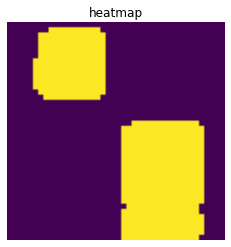

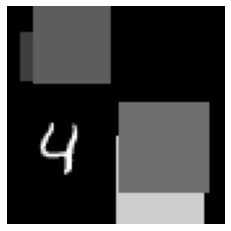

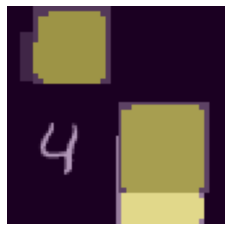

org_img  (84, 84, 3)  activation ma  (84, 84)


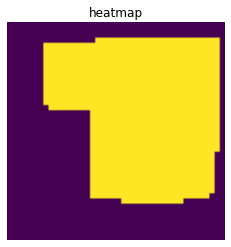

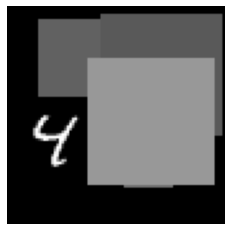

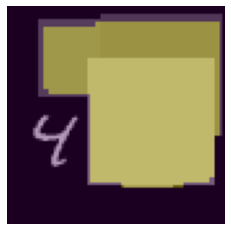

org_img  (84, 84, 3)  activation ma  (84, 84)


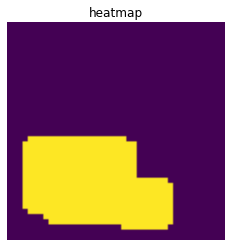

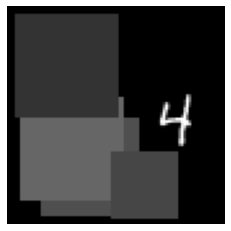

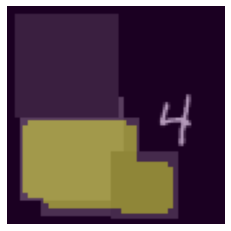

org_img  (84, 84, 3)  activation ma  (84, 84)


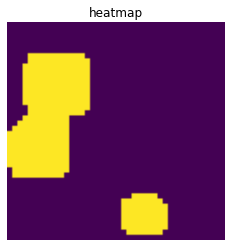

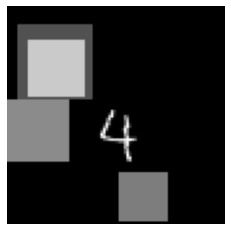

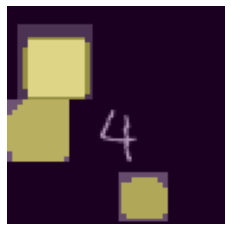

org_img  (84, 84, 3)  activation ma  (84, 84)


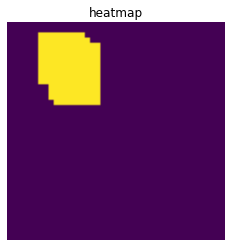

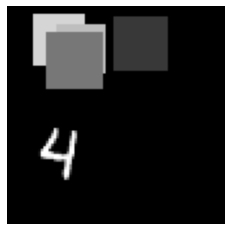

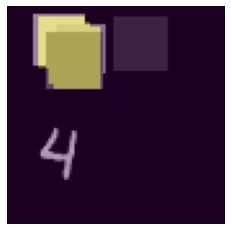

org_img  (84, 84, 3)  activation ma  (84, 84)


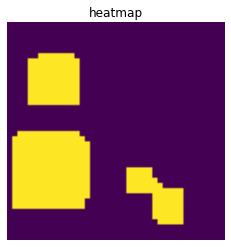

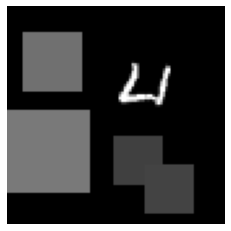

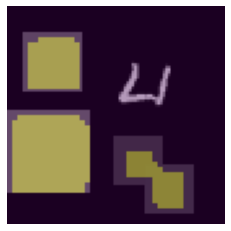

org_img  (84, 84, 3)  activation ma  (84, 84)


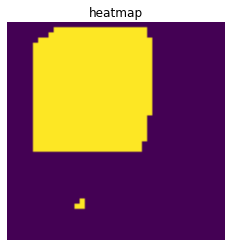

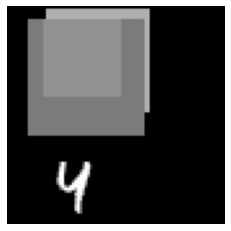

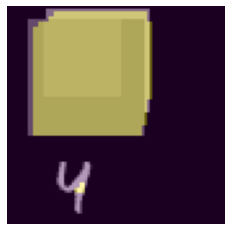

In [37]:
plot_heatmap(P_ij, all_data.clone(), dataset)

In [ ]:
print('all_data ', all_data.shape)
evaluate(P_ij, all_data, targets)